In [3]:
# import required libraries
import pandas as pd
import yfinance as yf
import numpy as np
import math 

In [20]:
# input ticker and parameters
ticker = 'EURAUD=X'
start_date = '2000-01-01'
end_date = '2022-01-01'
df = yf.download(ticker, start_date, end_date, threads= False)
df = df.reset_index()
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-12-01,1.6605,1.6613,1.6420,1.6433,1.6433,0
1,2003-12-02,1.6435,1.6547,1.6397,1.6505,1.6505,0
2,2003-12-03,1.6496,1.6538,1.6402,1.6441,1.6441,0
3,2003-12-04,1.6438,1.6484,1.6372,1.6412,1.6412,0
4,2003-12-05,1.6415,1.6563,1.6406,1.6542,1.6542,0


In [21]:
# parameter setup (default values in the original indicator)
length = 20
mult = 2
length_KC = 20
mult_KC = 1.5


# calculate Bollinger Bands
# moving average
m_avg = df['Close'].rolling(window=length).mean()
# standard deviation
m_std = df['Close'].rolling(window=length).std(ddof=0)
# upper Bollinger Bands
df['upper_BB'] = m_avg + mult * m_std
# lower Bollinger Bands 
df['lower_BB'] = m_avg - mult * m_std


# calculate Keltner Channel
# first we need to calculate True Range
df['tr0'] = abs(df["High"] - df["Low"])
df['tr1'] = abs(df["High"] - df["Close"].shift())
df['tr2'] = abs(df["Low"] - df["Close"].shift())
df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR
range_ma = df['tr'].rolling(window=length_KC).mean()
# upper Keltner Channel
df['upper_KC'] = m_avg + range_ma * mult_KC
# lower Keltner Channel
df['lower_KC'] = m_avg - range_ma * mult_KC


# calculate momentum value***
highest = df['High'].rolling(window = length_KC).max()
lowest = df['Low'].rolling(window = length_KC).min()
m1 = (highest + lowest) / 2
df['value'] = (df['Close'] - (m1 + m_avg)/2)
fit_y = np.array(range(0,length_KC))
df['value'] = df['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y, x, 1)[0] * (length_KC-1) + np.polyfit(fit_y, x, 1)[1], raw=True)

In [22]:
# add the change of momentum value***
df['change'] = df['value'].diff()

In [23]:
# entry point for long TQQQ:
# when value increases in the negative range (eg. from -10 to -9)
df['enter1_long'] = (df['change'] > 0) & (df['value'] < 0)
# exit point for long TQQQ:
# 1. when value decreases from positive to negative
df['exit1_long'] = (df['change'] < 0) & (df['value'].shift() > 0) & (df['value'] < 0)
# 2. when value decreases in the negative range (eg. from -9 to -10)
df['exit2_long'] = (df['change'] < 0) & (df['value'].shift() < 0 ) & (df['value'] < 0)


# entry point for long SQQQ:
# 1. when value decreases from positive to negative
df['enter1_short'] = df['exit1_long']
# 2. when value decreases in the nagtive range
df['enter2_short'] = (df['change'] < 0) & (df['value'] < 0)
# exit point for long SQQQ:
df['exit1_short'] = (df['change'] > 0) & (df['value'] < 0)

In [24]:
# simplification
df['buy_long'] = (df['enter1_long'].shift() == False) & (df['enter1_long'] == True)
df['close_long'] = (df['exit1_long'].shift() == False) & (df['exit1_long'] == True) | (df['exit2_long'].shift() == False) & (df['exit2_long'] == True)


df['buy_short'] = (df['enter1_short'].shift() == False) & (df['enter1_short'] == True) | (df['enter2_short'].shift() == False) & (df['enter2_short'] == True)
df['close_short'] = (df['exit1_short'].shift() == False) & (df['exit1_short'] == True) 

In [25]:
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,upper_BB,lower_BB,tr0,...,enter1_long,exit1_long,exit2_long,enter1_short,enter2_short,exit1_short,buy_long,close_long,buy_short,close_short
39,2004-01-23,1.6351,1.6406,1.6277,1.6319,1.6319,0,1.680266,1.615884,0.0129,...,True,False,False,False,False,True,True,False,False,True
40,2004-01-26,1.6285,1.6301,1.6163,1.6219,1.6219,0,1.676349,1.614211,0.0138,...,True,False,False,False,False,True,False,False,False,False
41,2004-01-27,1.6219,1.6243,1.6109,1.6212,1.6212,0,1.672155,1.613015,0.0134,...,True,False,False,False,False,True,False,False,False,False
42,2004-01-28,1.6212,1.6247,1.6128,1.6152,1.6152,0,1.667373,1.611777,0.0119,...,True,False,False,False,False,True,False,False,False,False
43,2004-01-29,1.6148,1.6342,1.6125,1.6278,1.6278,0,1.661220,1.613500,0.0217,...,True,False,False,False,False,True,False,False,False,False


In [26]:
capital = 1000
stop_loss_short = -0.05
take_profit_short = 0.06 # for shorting
stop_loss_long = -0.20

In [27]:
nav = capital
trades = []

for i in range(len(df)):
    if df['buy_long'].iloc[i] == True and i != (len(df) - 1):
        open_price = df['Open'].iloc[i + 1]
        open_date = df['Date'].iloc[i + 1]

        for j in range(i + 1, len(df)):
            
            current_price = df['Open'].iloc[j]
            change = current_price - open_price
            change_per = round(change / open_price, 2)
            
#             if(change_per < stop_loss_long):
#                 close_price = df['Open'].iloc[j + 1]
#                 close_date = df['Date'].iloc[j + 1]
#                 change = close_price - open_price
#                 change_per = round(change / open_price, 2)     
#                 nav = round(nav * (1 + change_per), 2)
                
#                 trade = []
#                 trade.append("LONG")
#                 trade.append("STOPLOSS")
#                 trade.append(nav)
#                 trade.append(change_per)
#                 trade.append(nav)
#                 trade.append(open_date)
#                 trade.append(close_date)
#                 trades.append(trade)
#                 break
                
            if df['close_long'].iloc[j] == True and j != (len(df) - 1):
            

                
                close_price = df['Open'].iloc[j + 1]
                close_date = df['Date'].iloc[j + 1]
                change = close_price - open_price
                change_per = round(change / open_price, 2)     
                nav = round(nav * (1 + change_per), 2)
                
                trade = []
                trade.append("LONG")
                trade.append("NORMAL")
                trade.append(nav)
                trade.append(change_per)
                trade.append(nav)
                trade.append(open_date)
                trade.append(close_date)
                trades.append(trade)
                break
                
    if df['buy_short'].iloc[i] == True and i != (len(df) - 1):
        open_price = df['Open'].iloc[i + 1]
        open_date = df['Date'].iloc[i + 1]
        
        for j in range(i + 1, len(df)):
            current_price = df['Open'].iloc[j]
            change = open_price - current_price
            change_per = round(change / open_price, 2)

            if change_per < stop_loss_short  and j != (len(df) - 1):
   
                close_price = df['Open'].iloc[j + 1]
                close_date = df['Date'].iloc[j+1]
                change = open_price - close_price
                change_per = round(change / open_price, 2)
                nav = round(nav * (1 + change_per), 2)
                
                trade = []
                trade.append("SHORT")
                trade.append("STOPLOSS")
                trade.append(nav)   
                trade.append(change_per)
                trade.append(nav)
                trade.append(open_date)
                trade.append(close_date)
                trades.append(trade)
                break
                
            if change_per > take_profit_short  and j != (len(df) - 1):
                close_price = df['Open'].iloc[j + 1]
                close_date = df['Date'].iloc[j + 1]
                change = open_price - close_price
                change_per = round(change / open_price, 2)
                nav = round(nav * (1 + change_per), 2)
                
                trade = []
                trade.append("SHORT")
                trade.append("TAKEPROFIT")
                trade.append(nav)   
                trade.append(change_per)
                trade.append(nav)
                trade.append(open_date)
                trade.append(close_date)
                trades.append(trade)
                break                
           
            
            if df['close_short'].iloc[j] == True  and j != (len(df) - 1):
   
                
                close_price = df['Open'].iloc[j + 1]
                close_date = df['Date'].iloc[j+1]
                change = open_price - close_price
                change_per = round(change / open_price, 2)
                nav = round(nav * (1 + change_per), 2)
                
                trade = []
                trade.append("SHORT")
                trade.append("NORMAL")
                trade.append(nav)   
                trade.append(change_per)
                trade.append(nav)
                trade.append(open_date)
                trade.append(close_date)
                trades.append(trade)
                break
           
    

In [28]:
# for each in range(len(trades)):
#     if(trades[each][0] == 'LONG'):
#         print(trades[each])

In [29]:
# for each in range(len(trades)):
#     if(trades[each][0] == 'SHORT'):
#         print(trades[each])

In [30]:
for each in range(len(trades)):
    print(trades[each])

['LONG', 'NORMAL', 990.0, -0.01, 990.0, Timestamp('2004-01-26 00:00:00'), Timestamp('2004-02-16 00:00:00')]
['SHORT', 'NORMAL', 980.1, -0.01, 980.1, Timestamp('2004-02-16 00:00:00'), Timestamp('2004-02-23 00:00:00')]
['LONG', 'NORMAL', 980.1, 0.0, 980.1, Timestamp('2004-02-23 00:00:00'), Timestamp('2004-02-24 00:00:00')]
['SHORT', 'NORMAL', 980.1, -0.0, 980.1, Timestamp('2004-02-24 00:00:00'), Timestamp('2004-03-04 00:00:00')]
['LONG', 'NORMAL', 980.1, -0.0, 980.1, Timestamp('2004-03-04 00:00:00'), Timestamp('2004-03-30 00:00:00')]
['SHORT', 'NORMAL', 1009.5, 0.03, 1009.5, Timestamp('2004-03-30 00:00:00'), Timestamp('2004-04-14 00:00:00')]
['LONG', 'NORMAL', 1110.45, 0.1, 1110.45, Timestamp('2004-04-14 00:00:00'), Timestamp('2004-06-30 00:00:00')]
['SHORT', 'NORMAL', 1132.66, 0.02, 1132.66, Timestamp('2004-06-30 00:00:00'), Timestamp('2004-07-16 00:00:00')]
['LONG', 'NORMAL', 1121.33, -0.01, 1121.33, Timestamp('2004-07-16 00:00:00'), Timestamp('2004-07-20 00:00:00')]
['SHORT', 'NORMAL'

In [31]:
first_date = trades[0][5]
last_date = trades[len(trades)-1][6]

df = df[df['Date'] >= first_date]
df = df[df['Date'] <= last_date]

price_of_stock = df['Open'].iloc[0]
num_of_shares = capital / price_of_stock

df['bnh'] = df['Open'] * num_of_shares
df

,Date,Open,High,Low,Close,Adj Close,Volume,upper_BB,lower_BB,tr0,...,exit1_long,exit2_long,enter1_short,enter2_short,exit1_short,buy_long,close_long,buy_short,close_short,bnh
40,2004-01-26,1.62850,1.63010,1.61630,1.62190,1.62190,0,1.676349,1.614211,0.01380,...,False,False,False,False,True,False,False,False,False,1000.000000
41,2004-01-27,1.62190,1.62430,1.61090,1.62120,1.62120,0,1.672155,1.613015,0.01340,...,False,False,False,False,True,False,False,False,False,995.947177
42,2004-01-28,1.62120,1.62470,1.61280,1.61520,1.61520,0,1.667373,1.611777,0.01190,...,False,False,False,False,True,False,False,False,False,995.517335
43,2004-01-29,1.61480,1.63420,1.61250,1.62780,1.62780,0,1.661220,1.613500,0.02170,...,False,False,False,False,True,False,False,False,False,991.587345
44,2004-01-30,1.62810,1.64010,1.62170,1.63480,1.63480,0,1.658232,1.614218,0.01840,...,False,False,False,False,True,False,False,False,False,999.754408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4697,2021-12-17,1.57945,1.58381,1.57557,1.57910,1.57910,0,1.608772,1.549482,0.00824,...,False,False,False,False,False,False,False,False,False,969.880274
4698,2021-12-20,1.57888,1.58986,1.57816,1.57965,1.57965,0,1.608337,1.551975,0.01170,...,False,False,False,False,False,False,False,False,False,969.530222
4699,2021-12-21,1.58559,1.58826,1.57780,1.58621,1.58621,0,1.607558,1.555843,0.01046,...,False,False,False,False,False,False,False,False,False,973.650611
4700,2021-12-22,1.57911,1.58291,1.56930,1.57909,1.57909,0,1.606110,1.559499,0.01361,...,True,False,True,True,False,False,True,True,False,969.671502


In [32]:
import matplotlib.pyplot as plt

equity_value_strat = []
date_strat = []

for i in range(len(trades)): 
    equity_value_strat.append(trades[i][4])
    date_strat.append(trades[i][6])

equity_value_bnh = []
date_bnh = [] 
for i in range(len(df)):
    equity_value_bnh.append(df['bnh'].iloc[i])
    date_bnh.append(df['Date'].iloc[i])
    
left = pd.DataFrame({'date': date_strat, 'strat': equity_value_strat})    
right = pd.DataFrame({'date': date_bnh, 'bnh': equity_value_bnh})  

result = pd.merge(left, right, how='left', on=["date"])
result

,date,strat,bnh
0,2004-02-16,990.00,987.780188
1,2004-02-23,980.10,996.315602
2,2004-02-24,980.10,997.543784
3,2004-03-04,980.10,999.140317
4,2004-03-30,980.10,998.526226
...,...,...,...
511,2021-10-07,1089.03,974.332194
512,2021-10-26,1110.81,951.249659
513,2021-10-27,1110.81,947.694169
514,2021-10-28,1110.81,949.603934


<AxesSubplot:title={'center':'Equity over Time'}, xlabel='date'>

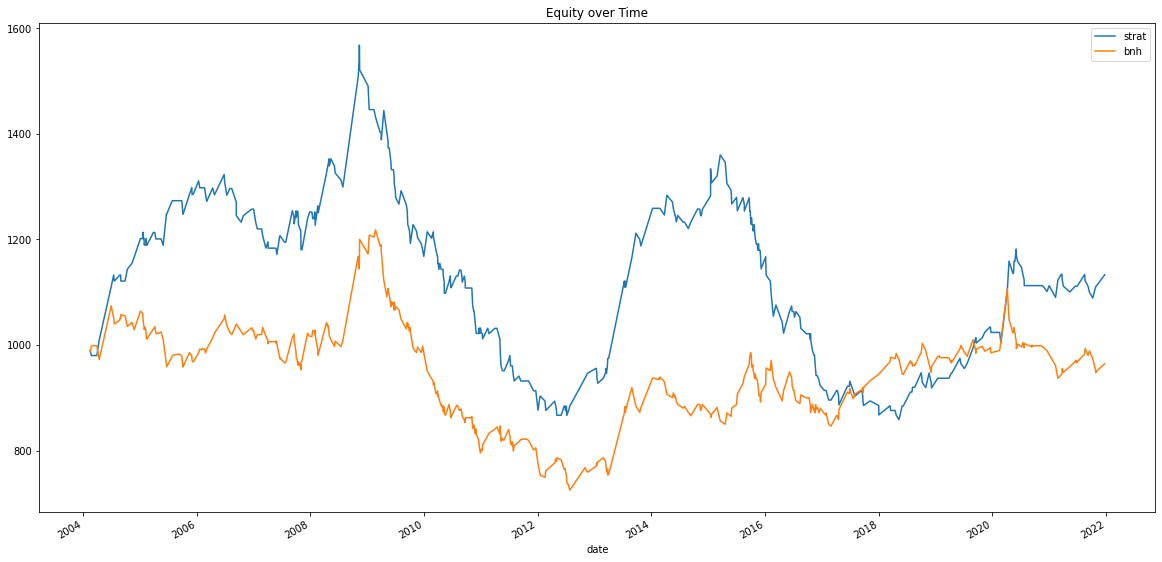

In [33]:
# plt.figure(figsize=(10, 8), dpi=80)
# plt.ylabel("Equity")
# plt.title("Equity over Time")
# plt.plot(date, equity_value_strat)
# plt.plot(date, equity_value_bnh)
# plt.legend()
# plt.show()
result.plot('date', 
            figsize = (20,10), title = 'Equity over Time')


In [34]:
returns = round(nav - capital,2)
returns_per = round(returns / capital * 100, 1)
years = (last_date - first_date).days/365
annualized_returns = round((pow((returns / capital),1/years)-1)*100,2)

final_bnh = round(result['bnh'].iloc[len(result) - 1],2)
returns_bnh = round(final_bnh - capital,2)
returns_per_bnh = round(returns_bnh / capital * 100, 1)
annualized_returns_bnh = round((pow((returns_bnh / capital),1/years)-1)*100,2)

print("ticker: ", ticker)
print("start date:", first_date.strftime('%Y-%m-%d'))
print("end date:", last_date.strftime('%Y-%m-%d'))
print("start amount: $", capital)
print(" ")
print("========== algo performance ==========")
print("final amount: $", nav)
print("returns: $", returns)
print("returns_per:", returns_per, "%")
print("annualized returns:", annualized_returns, "%")
print(" ")
print("====== buy and hold performance ======")
print("final amount: $", final_bnh)
print("returns: $", returns_bnh)
print("returns_per:", returns_per_bnh, "%")
print("annualized returns:", annualized_returns_bnh, "%")

ticker:  EURAUD=X
start date: 2004-01-26
end date: 2021-12-23
start amount: $ 1000
 
========== algo performance ==========
final amount: $ 1133.03
returns: $ 133.03
returns_per: 13.3 %
annualized returns: -10.65 %
 
====== buy and hold performance ======
final amount: $ 964.43
returns: $ -35.57
returns_per: -3.6 %
annualized returns: nan %


/var/folders/y_/nk7q1s1s0w3c20r04w1pjq0m0000gn/T/ipykernel_3338/1180893101.py:9: RuntimeWarning: invalid value encountered in double_scalars
  annualized_returns_bnh = round((pow((returns_bnh / capital),1/years)-1)*100,2)


In [35]:
win_count = 0
lose_count = 0
long_win_count = 0
long_lose_count = 0
short_win_count = 0
short_lose_count = 0

for each in range(len(trades)):
    if(trades[each][3] > 0):
        win_count += 1
        if(trades[each][0] == 'LONG'):
            long_win_count += 1
        else:
            short_win_count += 1
    else:
        lose_count += 1
        if(trades[each][0] == 'LONG'):
            long_lose_count += 1
        else:
            short_lose_count += 1
        
win_rate = round(win_count / (win_count + lose_count) * 100, 1)
long_win_rate = round(long_win_count / (long_win_count + long_lose_count) * 100, 1)
short_win_rate = round(short_win_count / (short_win_count + short_lose_count) * 100, 1)

print("========== overall trades ==========")
print("win count:", win_count)
print("lose count:", lose_count)
print("win rate:", win_rate, "%")

print("========== long trades ==========")
print("win count:", long_win_count)
print("lose count:", long_lose_count)
print("win rate:", long_win_rate, "%")

print("========== short trades ==========")
print("win count:", short_win_count)
print("lose count:", short_lose_count)
print("win rate:", short_win_rate, "%")

========== overall trades ==========
win count: 128
lose count: 388
win rate: 24.8 %
========== long trades ==========
win count: 58
lose count: 197
win rate: 22.7 %
========== short trades ==========
win count: 70
lose count: 191
win rate: 26.8 %
